##Fine-Tuning OpenAI Whisper Model for Audio Classification in PyTorch
https://www.daniweb.com/programming/computer-science/tutorials/540802/fine-tuning-openai-whisper-model-for-audio-classification-in-pytorch#post2294618
##Introduction
In a previous article, I explained how to fine-tune the vision transformer model for image classification in PyTorch. https://www.daniweb.com/programming/computer-science/tutorials/540749/fine-tuning-vision-transformer-for-image-classification-in-pytorch

In this article, I will explain how to fine-tune the pre-trained OpenAI Whisper model for audio classification in PyTorch.

Audio classification is an important task that can be applied in various scenarios, such as speech dialogue detection, sentiment analysis, music genre recognition, environmental sound identification, etc.

OpenAI Whisper is an excellent model for audio classification that achieved state-of-the-art results on several benchmarks. It is based on the transformer architecture and uses self-attention to process audio inputs. OpenAI Whisper can recognize speech and audio from different languages, accents, and domains with high accuracy and robustness.

In this article, you will see how to classify various sounds by fine-tuning the OpenAI Whisper model from Hugging Face in the PyTorch deep learning library. You will learn how to load the pre-trained model, prepare a custom audio dataset, train the model on the dataset, and evaluate the model performance. Let’s get started!


##Installing and Importing Required Libraries
You will need to install the Hugging Face Transformers library to run scripts in this article.



In [1]:
! pip install accelerate -U
! pip install datasets transformers[sentencepiece]


##Setup google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls /content/drive/MyDrive/UrbanSound8K

best_model_10epochs.bin  best_model.pt	fold3  fold7	   state_dict_10epochs
best_model_10epochs.pt	 fold1		fold4  fold8	   UrbanSound8K.csv
best_model.bin		 fold10		fold5  fold9	   UrbanSound8K.zip
best_model_dict.pt	 fold2		fold6  state_dict


The following script imports the Python libraries and modules required to execute Python codes in this article.

In [4]:
import datasets
from datasets import load_dataset, DatasetDict,  Audio
import pandas as pd
import os
import glob
import librosa
import io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score
from transformers import WhisperModel, WhisperFeatureExtractor, AdamW
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import f1_score, classification_report, accuracy_score


In [5]:
# display torch version and test if GPU is active
torch.__version__, torch.cuda.is_available()

('2.4.0+cu121', True)

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


Wed Sep 11 21:35:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Importing the datasets
This article will use the UrbanSound8K dataset from Kaggle. https://www.kaggle.com/datasets/chrisfilo/urbansound8k The dataset consists of audio files containing ten different sound categories. The audio files are located in 10 different folders. It is important to note that each folder may contain audio files belonging to all the categories. A CSV file is also downloaded with the dataset, containing details of each audio file.

The following script imports the CSV file into a Pandas DataFrame. The original dataset contains more than 8 thousand records. However, for the sake of experiments in this article, I randomly selected 2000 records.

In [7]:
audio_df = pd.read_csv(r"/content/drive/MyDrive/UrbanSound8K/UrbanSound8K.csv")
#audio_df = audio_df.sample(n=2000, random_state=42) ## 8732 total samples available
audio_df.head()


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


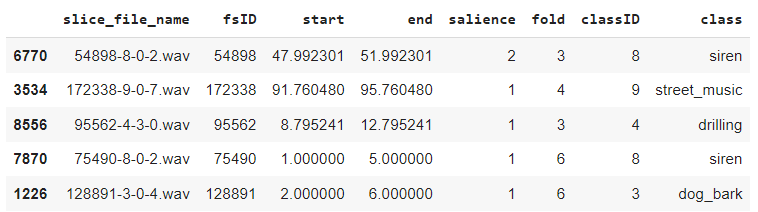

The slice_file_name column in the above DataFrame contains the audio file name. The classID and class columns contain corresponding class IDs and names.

Let's print the class distribution.

In [8]:
audio_df["class"].value_counts()


,count
class,
dog_bark,1000
children_playing,1000
air_conditioner,1000
street_music,1000
engine_idling,1000
jackhammer,1000
drilling,1000
siren,929
car_horn,429


You can see different sound categories in the dataset, e.g., street music, dog bark, siren, etc.

Next, we will create a column in the Pandas DataFrame containing the audio files' full path. To do so, we will first write a method that creates a dictionary mapping the audio file names to their corresponding full paths. Using this method, we will populate the full_path column in the audio_df DataFrame with the full paths of the audio files.

The get_all_full_paths() method in the following script returns a dictionary that maps the audio file names to their corresponding full paths.

In [9]:
def get_all_full_paths(parent_directory):
  # List to store file paths
  audio_file_paths = []

  # Iterate through audio folders (assuming they are named fold1, fold2, ..., fold10)
  for folder_name in range(1, 11):
      folder_path = os.path.join(parent_directory, 'fold{}'.format(folder_name))
      # Iterate through files in the current folder and add their paths to the list
      for filename in os.listdir(folder_path):
          if filename.endswith('.wav'):  # Assuming your audio files have .wav extension
              file_path = os.path.join(folder_path, filename)
              audio_file_paths.append(file_path)

  # Create a dictionary to map base name to full_path
  file_path_dict = {os.path.basename(path): path for path in audio_file_paths}
  return file_path_dict

audio_files_directory = '/content/drive/MyDrive/UrbanSound8K/'
file_path_dict = get_all_full_paths(audio_files_directory)


In [10]:
# list the wave files base names and full path directories
#file_path_dict

Next, we will define the get_single_full_path() method, which accepts the file name as a parameter and returns the corresponding full path from the dictionary returned by the get_all_full_paths() method. Subsequently, we will create a new column full_path in the audio_df DataFrame and use it's apply() method to store full paths in the full_path column.

In [11]:
def get_single_full_path(slice_file_name):
    return file_path_dict.get(slice_file_name)

# Add 'full_path' column to the DataFrame
audio_df['full_path'] = audio_df['slice_file_name'].apply(get_single_full_path)
audio_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,full_path
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,/content/drive/MyDrive/UrbanSound8K/fold5/1000...
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/fold5/1002...
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/fold5/1002...
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/fold5/1002...
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/fold5/1002...


Finally, we will split our dataset into training (70%), validation (15%), and test (15%) sets.



In [12]:
train_df, temp_df = train_test_split(audio_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

##Creating a PyTorch Dataset
The next step involves creating a PyTorch dataset. However, before that, we will create Hugging Face datasets using our audio files and labels.

This process converts the audio files into numeric arrays that you can pass to Hugging Face transformer models. You can create a Hugging Face dataset using the datasets.Dataset.from_dict() method. Pass the full path of the audio files to the audio key and cast the audios to a sampling rate of 16khz, the default sampling rate for the Hugging Face Whisper model. In addition, we will create a key for our target labels as well.

The following script creates Hugging Face datasets for train, test, and validation splits in our dataset.

In [13]:
train_audio_dataset = datasets.Dataset.from_dict({"audio": train_df["full_path"].tolist(),
                                                  "labels": train_df["classID"].tolist()    }
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))

test_audio_dataset = datasets.Dataset.from_dict({"audio": test_df["full_path"].tolist(),
                                                  "labels": test_df["classID"].tolist() }
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))

val_audio_dataset = datasets.Dataset.from_dict({"audio": val_df["full_path"].tolist(),
                                                  "labels": val_df["classID"].tolist()  }
                                                 ).cast_column("audio", Audio(sampling_rate=16_000))

You can use the dataset above for training with the Hugging Face trainer. However, we need to create a PyTorch dataset since we want to fine-tune the Whisper model in PyTorch.

You must extract audio features from your audio files to train a Whisper model. The WhisperFeatureExtractor object accomplishes this job.

The script below creates a Hugging Face Whisper model object and a WhisperFeatureExtractor object from the openai/whisper-base checkpoint. You can choose any other Whisper model checkpoint from Hugging Face if desired.

The code is configured to utilize the GPU if CUDA is available. Otherwise, it defaults to running on the CPU.

In [14]:
#model_checkpoint = "openai/whisper-base" ## multilingual, 74M parameters
model_checkpoint = "openai/whisper-small" ## multilingual, 224M parameters 11.5GB GPU RAM (fits in T4)

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_checkpoint)
encoder = WhisperModel.from_pretrained(model_checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

To create a PyTorch dataset for our problem, will define the SpeechClassificationDataset class that inherits the torch.utils.data.Dataset class. The SpeechClassificationDataset class returns the input features and decoder inputs for the Whisper model, along with the target labels.

In [15]:
class SpeechClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, audio_data,  text_processor):
        self.audio_data = audio_data
        self.text_processor = text_processor

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, index):

      inputs = self.text_processor(self.audio_data[index]["audio"]["array"],
                                   return_tensors="pt",
                                   sampling_rate=self.audio_data[index]["audio"]["sampling_rate"])
      input_features = inputs.input_features
      ##print('size of input features',input_features.size())
      decoder_input_ids = torch.tensor([[1, 1]]) * encoder.config.decoder_start_token_id

      labels = np.array(self.audio_data[index]['labels'])

      return input_features, decoder_input_ids, torch.tensor(labels)


Using the below script, we can transform our train_audio_dataset, test_audio_dataset, and val_audio_dataset Hugging Face datasets into PyTorch datasets. To process the datasets in batches, we create corresponding DataLoader objects with a batch size of 8.

In [16]:
train_dataset = SpeechClassificationDataset(train_audio_dataset,  feature_extractor)
test_dataset = SpeechClassificationDataset(test_audio_dataset,  feature_extractor)
val_dataset = SpeechClassificationDataset(val_audio_dataset,  feature_extractor)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##Fine Tuning Hugging Face Whisper Model
We are now prepared to fine-tune the Hugging Face Whisper model on our PyTorch dataset. To achieve this, we will design a model class that takes the Whisper model encoder as a parameter and passes the encoder's output through five dense layers (4096, 2048, 1024, and 512 neurons). The final dense layer will have ten labels, reflecting our ten target classes.

In [17]:

class SpeechClassifier(nn.Module):
    def __init__(self, num_labels, encoder):
        super(SpeechClassifier, self).__init__()
        self.encoder = encoder
        print("encoder output size",self.encoder.config.hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_features, decoder_input_ids):
        outputs = self.encoder(input_features, decoder_input_ids=decoder_input_ids)
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits



In the following script, we will instantiate an object of the SpeechClassifier class, specifying the number of labels (10 in our case), along with the loss function and optimizer.

In [18]:
num_labels = 10

model = SpeechClassifier(num_labels, encoder).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-08)
criterion = nn.CrossEntropyLoss()

##Training the Model
To train the model, we define the train() method and pass it the model, train and validation data loaders, optimizer, criterion (loss function), device, and the number of epochs as parameters. The train() method executes the training loop and prints the loss for each batch.



In [19]:
# Define the training function
def train(model, train_loader, val_loader, optimizer,  criterion, device, num_epochs):

    best_accuracy = 0.0

    for epoch in range(num_epochs):

        model.train()

        for i, batch in enumerate(train_loader):

            input_features, decoder_input_ids, labels = batch

            input_features = input_features.squeeze()
            input_features = input_features.to(device)

            decoder_input_ids = decoder_input_ids.squeeze()
            decoder_input_ids = decoder_input_ids.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            optimizer.zero_grad()

            logits = model(input_features, decoder_input_ids)

            loss = criterion(logits, labels)
            loss.backward()

            optimizer.step()

            if (i+1) % 8 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item() :.4f}')
                train_loss = 0.0

        val_loss, val_accuracy, val_f1, _ , _ = evaluate(model, val_loader, device)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')

        print("========================================================================================")
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Best Accuracy: {best_accuracy:.4f}')
        print("========================================================================================")



After every epoch, the train() method displays the loss, accuracy, and F-1 score on the validation set using the evaluate() method, defined in the subsequent script. Finally, the train() method saves the model with the highest accuracy on the validation set.

In [20]:
def evaluate(model, data_loader,  device):

    all_labels = []
    all_preds = []
    total_loss = 0.0

    with torch.no_grad():

        for i, batch in enumerate(data_loader):

          input_features, decoder_input_ids, labels = batch

          input_features = input_features.squeeze()
          input_features = input_features.to(device)

          decoder_input_ids = decoder_input_ids.squeeze()
          decoder_input_ids = decoder_input_ids.to(device)

          labels = labels.view(-1)
          labels = labels.to(device)

          optimizer.zero_grad()

          logits = model(input_features, decoder_input_ids)

          loss = criterion(logits, labels)
          total_loss += loss.item()

          _, preds = torch.max(logits, 1)
          all_labels.append(labels.cpu().numpy())
          all_preds.append(preds.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return loss, accuracy, f1, all_labels, all_preds


You can train the model by invoking the train() method. In the following script, I trained the model for 5 epochs. Feel free to adjust the number of epochs based on your requirements.

In [21]:
num_epochs = 20
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)
#Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/20, Batch 8/764, Train Loss: 2.2991
Epoch 1/20, Batch 16/764, Train Loss: 2.0803
Epoch 1/20, Batch 24/764, Train Loss: 1.6318
Epoch 1/20, Batch 32/764, Train Loss: 1.7138
Epoch 1/20, Batch 40/764, Train Loss: 1.6000
Epoch 1/20, Batch 48/764, Train Loss: 1.0849
Epoch 1/20, Batch 56/764, Train Loss: 0.7041
Epoch 1/20, Batch 64/764, Train Loss: 1.7553
Epoch 1/20, Batch 72/764, Train Loss: 0.9718
Epoch 1/20, Batch 80/764, Train Loss: 1.1186
Epoch 1/20, Batch 88/764, Train Loss: 1.1333
Epoch 1/20, Batch 96/764, Train Loss: 1.0307
Epoch 1/20, Batch 104/764, Train Loss: 0.6273
Epoch 1/20, Batch 112/764, Train Loss: 0.9793
Epoch 1/20, Batch 120/764, Train Loss: 1.1432
Epoch 1/20, Batch 128/764, Train Loss: 0.3128
Epoch 1/20, Batch 136/764, Train Loss: 0.5699
Epoch 1/20, Batch 144/764, Train Loss: 0.7948
Epoch 1/20, Batch 152/764, Train Loss: 1.2119
Epoch 1/20, Batch 160/764, Train Loss: 0.6273
Epoch 1/20, Batch 168/764, Train Loss: 0.7709
Epoch 1/20, Batch 176/764, Train Loss: 0.7509
E

After ten epochs, 2000 samples in the dataset, I got the best-case accuracy of 82.3% with the base model.

After two epochs, full dataset, I got 0.8687 Val Accuracy with the small model...


##Evaluating the Model
As a last step, we will test our trained model on an unseen test set. To achieve this, import the model with the best accuracy, which was saved during training, and pass it to the evaluate() method, along with the test dataset.

In [22]:
state_dict = torch.load('best_model.pt', weights_only=False) ## since we wrote the pickle file

# Create a new instance of the model and load the state dictionary
num_labels = 10
model = SpeechClassifier(num_labels, encoder).to(device)
model.load_state_dict(state_dict)
import time
t1 = time.perf_counter()

_, _, _, all_labels, all_preds = evaluate(model, test_loader, device)

t2 = time.perf_counter()
print('time taken to run prediction: ',t2-t1)

print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))


<ipython-input-22-dc93f3999026>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('best_model.pt')


              precision    recall  f1-score   support

           0       0.83      0.64      0.72        39
           1       1.00      0.89      0.94        18
           2       0.73      0.88      0.80        34
           3       0.97      0.91      0.94        33
           4       1.00      0.76      0.86        25
           5       0.73      0.89      0.80        27
           6       0.94      0.94      0.94        18
           7       0.83      0.92      0.87        37
           8       0.96      0.90      0.93        30
           9       0.74      0.82      0.78        39

    accuracy                           0.85       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.86      0.85      0.85       300

0.8466666666666667


We achieved an accuracy of 86.30% on the test set. Feel free to experiment by adding or removing dense and dropout layers and adjusting the learning rate to explore potential improvements.

I hope you found this tutorial helpful. You should now be able to fine-tune the OpenAI Whisper model from Hugging Face in your PyTorch scripts. If you have any questions or feedback, please feel free to leave them in the comments, and I will do my best to respond promptly.

##Save model to local drive, and to hugging face

In [23]:
#save model
torch.save(model.state_dict(),"/content/drive/MyDrive/UrbanSound8K/state_dict_20epochs" )
torch.save(model,"/content/drive/MyDrive/UrbanSound8K/best_model_20epochs.pt")
torch.save(model,"/content/drive/MyDrive/UrbanSound8K/best_model_20epochs.bin")

In [28]:
#push to huggingface
#trainer.push_to_hub("dedgington/best_model.pt")
#I did this by hand by using git to the hugging-face repo

NameError: name 'trainer' is not defined

##Using .bin files
.bin files in the context of PyTorch models typically represent the model's weights saved in a binary format. Here's what you need to know:
####Understanding .bin files:
#####Format:
These files contain the raw weights and biases of the model, stored in a binary format for efficiency.
#####Origin:
Often, .bin files are associated with models from Hugging Face's Transformers library.
#####Loading:
To load a .bin model, you'll typically use the from_pretrained() method within the relevant Transformers class.
#####Example:

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("path/to/model", from_flax=True)

####Alternatives to .bin:

*  .pt or .pth: These are the traditional formats for saving PyTorch models. They save the entire model object, including the architecture, weights, and optimizer state.
*   .safetensors: This is a newer format designed to be more secure and portable.


Converting .bin to .pt:
If you need to convert a .bin file to a .pt file, you can do so using the following steps:

In [ ]:
import torch
from transformers import AutoModelForCausalLM

# Load the model from the .bin file
model = AutoModelForCausalLM.from_pretrained("path/to/model", from_flax=True)

# Save the model as a .pt file
torch.save(model.state_dict(), "path/to/model.pt")

Serialize the state disctionary and save it to the specified file ('model.bin' in this case).

In [ ]:
torch.save(model.state_dict(), 'model.bin')